# Odhad $\pi$ metodou Monte Carlo

In [44]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import random

## První postup: samplujeme body

Vyrobíme si ``rep`` bodů z čtverce o hraně 2, spočteme podíl bodů, které leží v jednotkovém kruhu. (A vynásobíme 4, abychom dostali $\pi$.)
Podle zákona velkých čísel to funguje, pro dostatečně velké ``rep``.

Užitek této metody není ve výpočtu kruhu (to umíme) ani odhad $\pi$ (to jde mnohem přesněji jinak). Smysl této metody je ve výpočtu pravděpodobností, které přímo spočítat neumíme. Kruh jsme zvolili pro kontrolu, jestli nám to vychází.

In [49]:
def pi_est_basic(rep=10**4):
    succ = 0

    for _ in range(rep):
        x = random.uniform(-1,1)
        y = random.uniform(-1,1)        
        if x**2 + y**2 <= 1: succ += 1

    return 4*succ/rep

In [157]:
pi_est()

3.1532

Ukázka toho, jak se přesnost zvyšuje s počtem bodů (potřebujeme zhruba $100\times$ více bodů na jedno další desetinné místo).

In [156]:
%time print(pi_est(rep=10**2)-np.pi)
%time print(pi_est(rep=10**4)-np.pi)
%time print(pi_est(rep=10**6)-np.pi)
%time print(pi_est(rep=10**8)-np.pi)

-0.02159265358979301
CPU times: user 622 µs, sys: 743 µs, total: 1.37 ms
Wall time: 5.97 ms
0.016007346410206846
CPU times: user 617 µs, sys: 737 µs, total: 1.35 ms
Wall time: 3.92 ms
-0.0011966535897931507
CPU times: user 25.6 ms, sys: 0 ns, total: 25.6 ms
Wall time: 27.5 ms
-0.0004111335897931667
CPU times: user 1.6 s, sys: 8.42 s, total: 10 s
Wall time: 10 s


Totéž stručněji, pomocí ``numpy``.

In [57]:
def pi_est_np(rep=10**4):
    x = stats.uniform.rvs(-1,1,size=rep)
    y = stats.uniform.rvs(-1,1,size=rep)
    
    return 4*(x**2+y**2 <= 1).mean()

Zdá se, že obě metody jsou stejně rychlé. (Jak poznat, jestli drobné rozdíly jsou chyba měření, nebo efektivnější implemetnace? Již brzy ve statistické části.)

In [226]:
timeit('pi_est_basic()')

4.38 ns ± 0.0693 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [227]:
timeit('pi_est_np()')

4.42 ns ± 0.0634 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [35]:
pi_est(rep=10**6)

3.140676

Co můžeme čekat, od jednotlivých výsledků měření? 

In [158]:
L = [pi_est(rep=10**4) for _ in range(10**4)]

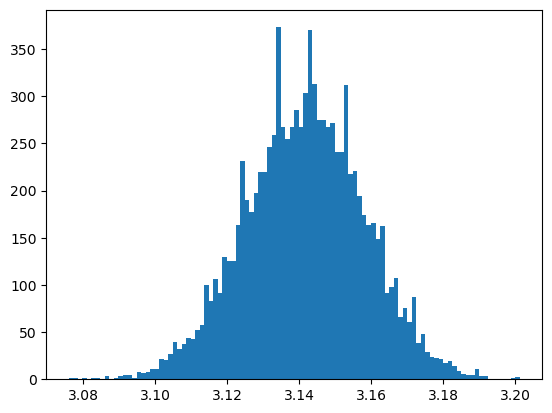

In [163]:
plt.hist(L, bins=100);

## Druhý postup -- odhadujeme integrál

Ze základního významu integrálu (plocha pod křivkou) je jasné, že plocha čtvrtkruhu je 
$\int_0^1 \sqrt{1-x^2} dx$. To můžeme v tomto případě přesně vyčíslit (substitucí $x = \cos t$), nebo spočítat numericky. 

Ukážeme si postup, který funguje vždy (a v některých případech, zejména pro vícerozměrné integrály, funguje nejlépe ze známých metod). 
Opět, funkčnost metody je založena na zákonech velkých čísel. 

Používáme zde jen základy této metody, další detaily pro zájemce na wiki stránce o [Monte Carlo integrování](https://en.wikipedia.org/wiki/Monte_Carlo_integration). 


Btw, ten první postup se dá také chápat jako výpočet integrálu, z funkce definované na $[-1,1]^2$, která nabývá hodnoty $1$ uvnitř kruhu a $0$ mimo. 

A jak tedy budeme postupovat? Odhadujeme střední hodnotu náhodné veličiny $\sqrt{1-X^2}$, kde $X \sim U(0,1)$. 
To je rovno zadanému integrálu [PNS](https://en.wikipedia.org/wiki/Law_of_the_unconscious_statistician). Na druhou stranu můžeme podle 
[zákona velkých čísel](https://en.wikipedia.org/wiki/Law_of_large_numbers) prostě zprůměrovat dostatečný počet vzorků náhodné 
veličiny $\sqrt{1-X^2}$. 

In [228]:
def pi_est_2(rep=10**4):
    x = stats.uniform.rvs(0,1,size=rep)    
    return 4*(np.sqrt(1-x**2)).mean()

In [232]:
timeit('pi_est_basic()')

4.43 ns ± 0.0168 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [231]:
timeit('pi_est_2()')

4.4 ns ± 0.0198 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [230]:
pi_est_2(rep=10**6)

3.1417461513164135

In [240]:
L = [pi_est_basic(rep=10**4) for _ in range(10**4)]
L2 = [pi_est_2(rep=10**4) for _ in range(10**4)]

In [241]:
np.mean(L),np.mean(L2)

(3.1417679999999995, 3.1415485612696115)

In [242]:
np.std(L),np.std(L2)

(0.016531484627824566, 0.008904641563311758)

Opět vyzkoušíme, co můžeme čekat od jednotlivých výsledků měření? 

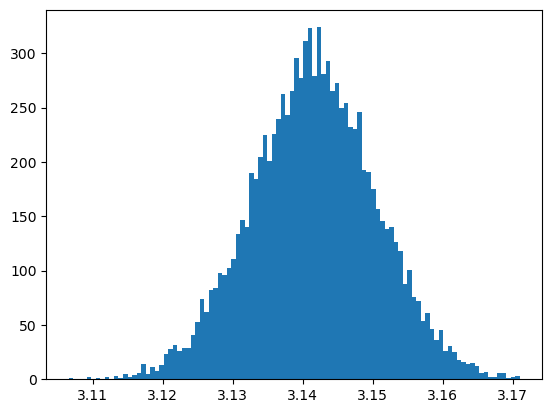

In [234]:
plt.hist(L2, bins=100);

Statistické testy ukazují, že výsledky našeho samplování $\pi$ jsou (přibližně) normální. (Testování hypotéz už brzy 
-- stručně, nízká ``pvalue`` by znamenala, že rozdělení asi není normální.)

In [245]:
stats.normaltest(L)

NormaltestResult(statistic=1.3960798907879095, pvalue=0.4975595926211347)

In [246]:
stats.normaltest(L2)

NormaltestResult(statistic=2.1986034352037738, pvalue=0.33310360288924806)

Proto podle [pravidla 68-95-99.7](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) můžeme tušit, v kolika procentech případů nám test dá hodnotu od $\pi$ vzdálenou o $\sigma$, $2\sigma$, $3\sigma$: 

In [247]:
for c in [1,2,3]: 
    print(c, np.mean([ abs(x-np.pi)>0.0165*c for x in L ]))

1 0.3142
2 0.0462
3 0.0026
